In [1]:
%%HTML
<style type="text/css">
                                       
div.h2 {
    background-color: #3E5AE6;
    background-image: linear-gradient(120deg, #3E5AE6, #A37CE6);
    text-align: left;
    color: white;              
    padding:9px;
    padding-right: 100px; 
    font-size: 20px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 40px; 
}                                  
                                      
body {
  font-size: 12px;
}    
                                                                               
div.h3 {
    color: #3E5AE6; 
    font-size: 18px; 
    margin-top: 20px; 
    margin-bottom:4px;
}
                                     
div.h4 {
    color: #159957;
    font-size: 15px; 
    margin-top: 20px; 
    margin-bottom: 8px;
}
                                         
span.note {
    font-size: 5; 
    color: gray; 
    font-style: italic;
}
                                        
hr {
    display: block; 
    color: gray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}
  
                                      
hr.light {
    display: block; 
    color: lightgray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}   
                                         
table.dataframe th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
}
                                       
table.dataframe td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
    text-align: center;
} 
                                         
table.rules th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
}
                                          
table.rules td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 13px;
    text-align: center;
} 
                                      
                                      
table.rules tr.best
{
    color: green;
}    
                                       
.output { 
    align-items: center; 
}
                                      
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}                                          
                                                                                                                                                                                                                                      
</style>  

# **Movie Recommendation System using Spark**

# **Group Members:**

1. Sanya Zaveri AU1920064
2. Kavya Patel AU1940144
3. Kairavi Shah AU1940177

In [2]:
!pip install -U vega_datasets notebook vega

     |████████████████████████████████| 210 kB 4.5 MB/s 
     |████████████████████████████████| 9.9 MB 58.2 MB/s 
     |████████████████████████████████| 1.3 MB 63.4 MB/s 
     |████████████████████████████████| 427 kB 61.7 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
ERROR: vega 3.6.0 has requirement pandas<2.0.0,>=1.0.0, but you'll have pandas 0.25.3 which is incompatible.
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
  Attempting uninstall: Send2Trash
    Found existing installation: Send2Trash 1.5.0
    Uninstalling Send2Trash-1.5.0:
      Successfully uninstalled Send2Trash-1.5.0
  Attempting uninstall: notebook
    Found existing installation: notebook 5.5.0
    Uninstalling notebook-5.5.0:
      Successfully uninstalled notebook-5.5.0


In [3]:
!pip install ujson

In [4]:
%env JOBLIB_TEMP_FOLDER=/tmp
!pip install pyspark

env: JOBLIB_TEMP_FOLDER=/tmp
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 31.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853644 sha256=39e6e058da4e6ced326db0461ccf258eac530665bb1c94ded24ab5dfbe8b310f
  Stored in directory: /root/.cache/pip/wheels/bc/fa/63/f112e9bf64fa59f349f9d37b48b70911435dc532ff49cffddc
Successfully built pyspark


In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)
import os
import gc
import ujson as json
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import plot,iplot

init_notebook_mode(connected=True)

import altair as alt
from altair.vega import v5
from IPython.display import HTML
alt.renderers.enable('notebook')

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.core.display import display
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn') 
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%config InlineBackend.figure_format = 'svg'  
th_props = [('font-size', '13px'), ('background-color', 'white'), ('color', '#666666')]
td_props = [('font-size', '15px'), ('background-color', 'white')]
styles = [dict(selector="td", props=td_props), dict(selector="th", props=th_props)]

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

DATA_PATH = '../input/the-movies-dataset/'

In [6]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           
@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

It's time to take a look in all files provided by the dataset.

In [7]:
print('Data Files in Directory')
print(os.listdir(DATA_PATH))

Data Files in Directory
['ratings.csv', 'links_small.csv', 'credits.csv', 'keywords.csv', 'movies_metadata.csv', 'ratings_small.csv', 'links.csv']


For now, I will ignore all small dataset versions.<br>
Time to import relvant (Ratings, Links and Metadata) files and check the data.

In [8]:
ratings = pd.read_csv(DATA_PATH+'ratings.csv')
links = pd.read_csv(DATA_PATH+'links.csv')
metadata = pd.read_csv(DATA_PATH+'movies_metadata.csv')

In [9]:
# Function that I wrote to print all relevant infos in dataset
import io

def get_df_info(df):
    display(df.head(3))
    buf = io.StringIO()
    df.info(buf=buf)
    info = buf.getvalue().split('\n')[-2]
    display(f'Number of Rows: {df.shape[0]}, Number of Columns: {df.shape[1]}')
    display('Data Types')
    df_types = df.dtypes
    df_types = pd.DataFrame({'Column':df_types.index, 'Type':df_types.values})
    display(df_types) 
    display(info)
    missing = df.isnull().sum().sort_values(ascending=False)
    display('Missing Values')
    if missing.values.sum() == 0:
        display('No Missing Values')
    else:
        missing = missing[missing > 0]
        missing = pd.DataFrame({'Column' : missing.index, 'Missing Values' : missing.values})
        display(missing)

<a id='bkground'></a>
<div class="h3"><center>Ratings Content</center></div>

In [10]:
get_df_info(ratings)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


'Number of Rows: 26024289, Number of Columns: 4'

'Data Types'

,Column,Type
0,userId,int64
1,movieId,int64
2,rating,float64
3,timestamp,int64


'memory usage: 794.2 MB'

'Missing Values'

'No Missing Values'

<a id='bkground'></a>
<div class="h3"><center>Metadata Content</center></div>

In [11]:
get_df_info(metadata)

,adult,belongs_to_collection,budget,genres,...,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",...,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",...,Grumpier Old Men,False,6.5,92.0


'Number of Rows: 45466, Number of Columns: 24'

'Data Types'

,Column,Type
0,adult,object
1,belongs_to_collection,object
2,budget,object
3,genres,object
4,homepage,object
5,id,object
6,imdb_id,object
7,original_language,object
8,original_title,object
9,overview,object


'memory usage: 8.3+ MB'

'Missing Values'

,Column,Missing Values
0,belongs_to_collection,40972
1,homepage,37684
2,tagline,25054
3,overview,954
4,poster_path,386
5,runtime,263
6,status,87
7,release_date,87
8,imdb_id,17
9,original_language,11


In all the data info displayed, we can see that only ratings have a large memory usage, and I will use this dataset to make the recommendation system based on user ratings, the dataset have the relevant data like userId, movieId and ratings.<br>
It's important to say that the ratings dataset doesn't have any missing value, therefore, will not needed any treatment like data imputation or drop NA rows.<br>
The other datasets will be used for Exploratory Data Analysis.


<br>
<a id='bkground'></a>
<div class="h2"><center>Exploratory Data Analysis</center></div>
<br>

<div class="h3">Let's start with the following approaches</div><br>
* Rating Frequency.
* Analysis of most rated movies.
* World cloud with most common words.

Let's start plotting an Histogram to see the rating distribution.

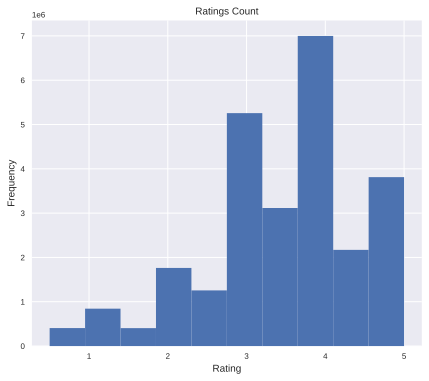

In [12]:
plt.rcParams['figure.figsize'] = (7, 6)
plt.hist(ratings['rating'], bins=10);
plt.title('Ratings Count', size=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show();

And for a better visualization, let's represent by a pie chart with the percent representation.

In [13]:
values = ratings.rating.value_counts()
labels = values.index
colors = ['red', 'blue', 'green', 'yellow', 'black']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Ratings by Total Percent')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

We can see most movies were rated with 4, on a scale of 1 to 5. A fewer movies (compared to the total dataset) were rated with low grades. <br>
Let's see which movies were rated most times, taking the 10 most rated.

In [14]:
df_aux = ratings['movieId'].value_counts().reset_index().head(10).rename(columns={'index': 'movieId', 'movieId': 'count'})
df_aux['movieId'] = df_aux['movieId'].astype(str)

In [15]:
render(alt.Chart(df_aux).mark_bar().encode(
    x=alt.X('movieId:N', axis=alt.Axis(title='Movie ID'), sort=list(df_aux['movieId'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Total Count')),
    tooltip=['movieId', 'count']
).properties(title='Movie Count', height=300, width=800).interactive())

Time to discover which movies have this IDs.<br> 
Let's check the IDs on IMDB and get some info.

In [16]:
# Get the Movie on metadata
def get_movie_metadata(movieId):
    metadata['imdb_id'] = metadata['imdb_id'].astype('category')
    imdb_id = links[links['movieId'] == movieId]
    imdb_id = imdb_id.imdbId.values[0]
    if len(str(imdb_id)) == 7:
        movie_rated = metadata[metadata['imdb_id'] == 'tt'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 6:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 5:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 4:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 3:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 2:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 1:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    else:
        pass
# Get Movie List
def get_movie(df):
    movieIdIdx = df['movieId'].values.astype(int)
    df_aux_b = pd.DataFrame({'title': ['aaa'], 
                           'overview': ['bbb'], 
                           'vote_average': [1.7], 
                           'release_date': ['1999-01-01']
        })
    for i in movieIdIdx:
        df_aux_b = df_aux_b.append(get_movie_metadata(i), ignore_index=True)

    df_aux_b.drop(0, inplace=True)
    df_aux_b['release_date'] = df_aux_b['release_date'].apply(lambda x : x.split('-')[0])
    df_aux_b['release_date'] = df_aux_b['release_date'].astype(int)
    df_aux_b.rename(columns={'release_date' : 'release_year'}, inplace=True)
    return df_aux_b.reset_index(drop=True)

In [17]:
df_movies = get_movie(df_aux)
df_movies

,title,overview,vote_average,release_year
0,Forrest Gump,A man with a low IQ has accomplished great thi...,8.2,1994
1,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,8.5,1994
2,Pulp Fiction,"A burger-loving hit man, his philosophical par...",8.3,1994
3,The Silence of the Lambs,"FBI trainee, Clarice Starling ventures into a ...",8.1,1991
4,The Matrix,"Set in the 22nd century, The Matrix tells the ...",7.9,1999
5,Star Wars,Princess Leia is captured and held hostage by ...,8.1,1977
6,Jurassic Park,A wealthy entrepreneur secretly creates a them...,7.6,1993
7,Schindler's List,The true story of how businessman Oskar Schind...,8.3,1993
8,Braveheart,"Enraged at the slaughter of Murron, his new br...",7.7,1995
9,Toy Story,"Led by Woody, Andy's toys live happily in his ...",7.7,1995



Another curious information is that in the most rated movies, none have a rate above 9.0.<br>
Let's expand it, let's get all the 1000 most rated movies and examine what words are frequent in they overviews.

In [18]:
df_aux = ratings['movieId'].value_counts().reset_index().head(1001).rename(columns={'index': 'movieId', 'movieId': 'count'})
df_aux['movieId'] = df_aux['movieId'].astype(str)
df_aux = get_movie(df_aux)
get_df_info(df_aux)

,title,overview,vote_average,release_year
0,Forrest Gump,A man with a low IQ has accomplished great thi...,8.2,1994
1,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,8.5,1994
2,Pulp Fiction,"A burger-loving hit man, his philosophical par...",8.3,1994


'Number of Rows: 1000, Number of Columns: 4'

'Data Types'

,Column,Type
0,title,object
1,overview,object
2,vote_average,float64
3,release_year,int64


'memory usage: 31.4+ KB'

'Missing Values'

'No Missing Values'

Time to use Natural Language Processing (NLP) with NLTK module and transform everything in overview for lower case, word tokens and remove stopwords and make the Word Cloud.

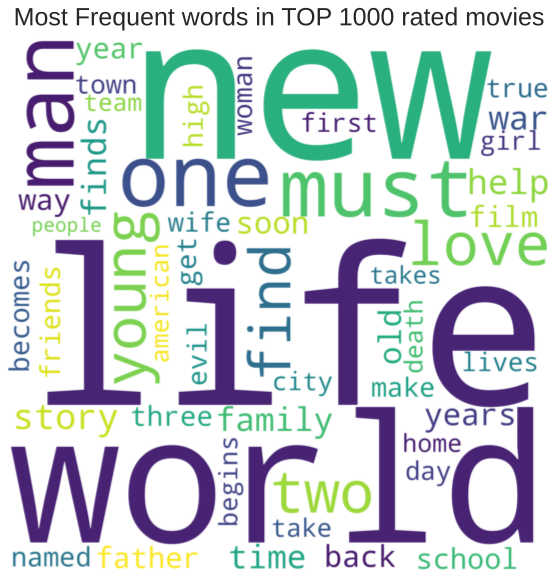

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

df_aux['overview'] = df_aux.overview.apply(lambda x : x.lower())
df_aux['overview'] = df_aux.overview.apply(lambda x : tokenizer.tokenize(x))
df_aux['overview'] = df_aux.overview.apply(lambda x : [w for w in x if w not in stop_words])
df_aux['overview'] = df_aux.overview.apply(lambda x : ' '.join(x))

word_count = df_aux.overview.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
word_count = pd.DataFrame({'word' : word_count.index, 'count': word_count.values})
# Plot the WordCloud
d = {}
for a, x in word_count.values:
    d[a] = x

wordcloud = WordCloud(background_color = 'white',
                      max_words = 50,
                      width = 2000,
                      height = 2000)
wordcloud.generate_from_frequencies(frequencies=d)
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most Frequent words in TOP 1000 rated movies', fontsize = 25)
plt.show();

In [20]:
del ratings, df_aux, df_movies
gc.collect()

1646

<br>
<a id='bkground'></a>
<div class="h2"><center>Model using PySpark</center></div>
<br>

Let's start importing all needed models and setting Spark.

In [21]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local')
spark = SparkSession(sc)

/opt/conda/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning:

Python 3.6 support is deprecated in Spark 3.2.



Create the Schema.

In [22]:
data_schema = StructType([
    StructField('userId', IntegerType(), False),
    StructField('movieId', IntegerType(), False),
    StructField('rating', FloatType(), False),
    StructField('timestamp',IntegerType(), False)
])
final_stat = spark.read.csv(
    '/kaggle/input/the-movies-dataset/ratings.csv', header=True, schema=data_schema
).cache()

ratings = (final_stat.select(
    'userId',
    'movieId',
    'rating'
)).cache()

Split in Train (70%) and Test (30%).

In [23]:
(training, test) = ratings.randomSplit([0.7, 0.3], seed=42)

And train the model, the evaluation will be made on test set using Mean Absolute Error (MAE).

In [24]:
als = ALS(
          rank=30,
          maxIter=4, 
          regParam=0.1,
          userCol='userId', 
          itemCol='movieId', 
          ratingCol='rating',
          coldStartStrategy='drop',
          implicitPrefs=False
         )
model = als.fit(training)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='mae', labelCol='rating',
                                predictionCol='prediction')

mae = evaluator.evaluate(predictions)
print(f'MAE (Test) = {mae}')

MAE (Test) = 0.6645168928085002


And finally, generate the Best recommendation for each user (User Based Recommendation System).
The movieId, the first element in recommendations vector, is the same of ratings dataframe.

In [25]:
model.recommendForAllUsers(1).show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{101862, 6.98694...|
|     2| [{141359, 4.52696}]|
|     3|[{158832, 4.13699...|
|     4|[{164937, 5.637266}]|
|     5|[{164937, 6.243306}]|
+------+--------------------+
only showing top 5 rows



Let's see which movie was recommended for a particular userId.

In [26]:
get_movie_metadata(156589)

,title,overview,vote_average,release_date
0,Hate Story 2,The movie is a revenge thriller with Surveen C...,4.5,2014-07-18


Show the most recommended user for each movie (Item Based Recommendation System).
Again, the movieId is the same of ratings dataframe.

In [27]:
model.recommendForAllItems(1).show(10)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|      1|[{223872, 5.46453...|
|      2|[{266766, 5.049763}]|
|      3|[{43804, 4.8345737}]|
|      4|[{41755, 4.7486944}]|
|      5|[{179759, 5.18833...|
|      6|[{109698, 5.38298...|
|      7|[{179759, 5.203492}]|
|      8|[{212857, 5.044653}]|
|      9| [{48043, 4.794549}]|
|     10|[{238716, 5.12752...|
+-------+--------------------+
only showing top 10 rows



And this finish the work!